In [1]:
!nvidia-smi

Mon May 10 08:02:18 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.06    Driver Version: 450.51.06    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P0    30W / 250W |      0MiB / 16280MiB |      4%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Identify Plant Diseases

We use the PlantVillage dataset [1] by Hughes et al. consists of about 87,000 healthy and unhealthy leaf images divided into 38 categories by species and disease. Here we provide a subset of our experiments on working with this data. We also end up transfer learning from MobileNet and use the weights from pre-training on ImageNet.

* ![PlantVillage Dataset Samples](https://i.imgur.com/Zcxdrlc.png)
Figure 1. PlantVillage Dataset Samples

## Classes

The following 38 classes are availaible in the dataset

- `Apple___Apple_scab` 
- `Apple___Black_rot` 
- `Apple___Cedar_apple_rust` 
- `Apple___healthy` 
- `Blueberry___healthy` 
- `Cherry_(including_sour)___Powdery_mildew` 
- `Cherry_(including_sour)___healthy` 
- `Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot` 
- `Corn_(maize)___Common_rust_` 
- `Corn_(maize)___Northern_Leaf_Blight` 
- `Corn_(maize)___healthy', 'Grape___Black_rot` 
- `Grape___Leaf_blight_(Isariopsis_Leaf_Spot)` 
- `Grape___healthy` 
- `Orange___Haunglongbing_(Citrus_greening)` 
- `Peach___Bacterial_spot` 
- `Peach___healthy` 
- `Pepper,_bell___Bacterial_spot` 
- `Pepper,_bell___healthy` 
- `Potato___Early_blight` 
- `Potato___Late_blight` 
- `Potato___healthy` 
- `Raspberry___healthy` 
- `Soybean___healthy` 
- `Squash___Powdery_mildew` 
- `Strawberry___Leaf_scorch` 
- `Strawberry___healthy` 
- `Tomato___Bacterial_spot` 
- `Tomato___Late_blight` 
- `Tomato___Leaf_Mold` 
- `Tomato___Septoria_leaf_spot` 
- `Tomato___Spider_mites Two-spotted_spider_mite` 
- `Tomato___Target_Spot` 
- `Tomato___Tomato_Yellow_Leaf_Curl_Virus` 
- `Tomato___Tomato_mosaic_virus` 
- `Tomato___healthy`

## References

[1] Hughes, David P., and Marcel Salathe. “An Open Access Repository of Images on Plant Health to Enable the Development of Mobile Disease Diagnostics.” ArXiv:1511.08060 [Cs], Apr. 2016. arXiv.org, http://arxiv.org/abs/1511.08060.

[2] Howard, Andrew G., et al. “MobileNets: Efficient Convolutional Neural Networks for Mobile Vision Applications.” ArXiv:1704.04861 [Cs], Apr. 2017. arXiv.org, http://arxiv.org/abs/1704.04861.


## Setup

In [2]:
import tensorflow as tf
from tensorflow import keras

import matplotlib.pyplot as plt
import numpy as np

import os

In [3]:
image_size = 224
target_size = (image_size, image_size)
input_shape = (image_size, image_size, 3)

batch_size = 64
epochs = 100

## Get data

In order to make the most of our few training examples, we will "augment" them via a number of random transformations, so that our model would never see twice the exact same picture. This helps prevent overfitting and helps the model generalize better.

In TensorFlow this can be done via the `tf.keras.preprocessing.image.ImageDataGenerator` class. This class allows you to:

- configure random transformations and normalization operations to be done on your image data during training
- instantiate generators of augmented image batches (and their labels) via `.flow(data, labels)` or `.flow_from_directory(directory)`. These generators can then be used with the `tf.keras` model methods that accept data generators as inputs, `fit`, `evaluate` and `predict`.

In [4]:
base_dir = "../input/new-plant-diseases-dataset/new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)"
train_dir = os.path.join(base_dir,"train")
test_dir = os.path.join(base_dir,"valid")

We make the following augmentations to the images:

- `width_shift` and `height_shift` are ranges (as a fraction of total width or height) within which to randomly translate pictures vertically or horizontally
- `rescale` is a value by which we will multiply the data before any other processing. Our original images consist in RGB coefficients in the 0-255, but such values would be too high for our models to process (given a typical learning rate), so we target values between 0 and 1 instead by scaling with a 1/255. factor.
- `shear_range` is for randomly applying shearing transformations
- `zoom_range` is for randomly zooming inside pictures
- `fill_mode` is the strategy used for filling in newly created pixels, which can appear after a rotation or a width/height shift.

In [5]:
train_datagen = keras.preprocessing.image.ImageDataGenerator(rescale = 1/255.0,
                                                             shear_range = 0.2,
                                                             zoom_range = 0.2,
                                                             width_shift_range = 0.2,
                                                             height_shift_range = 0.2,
                                                             fill_mode="nearest")

test_datagen = keras.preprocessing.image.ImageDataGenerator(rescale = 1/255.0)

Let's prepare our data. We will use `.flow_from_directory()` to generate batches of image data (and their labels) directly from our images in their respective folders.

In [6]:
train_data = train_datagen.flow_from_directory(train_dir,
                                               target_size = (image_size, image_size),
                                               batch_size = batch_size,
                                               class_mode = "categorical")

test_data = test_datagen.flow_from_directory(test_dir,
                                             target_size = (image_size, image_size),
                                             batch_size = batch_size,
                                             class_mode = "categorical")

Found 70295 images belonging to 38 classes.
Found 17572 images belonging to 38 classes.


## Create a classes index file

We also want to know which class corresponds to which species and disease so we also create a `json` file which shows corresponding labels and class indices.

In [7]:
# categories = list(train_data.class_indices.keys())
# print(train_data.class_indices)

In [8]:
# import json
# with open('class_indices.json','w') as f:
#   json.dump(train_data.class_indices, f)

# from IPython.display import FileLink
# FileLink(r'class_indices.json')

## Training

We first get the base MobileNet model without including the top layers since we want to use it for 38 classes and us the pre-trained weights for ImageNet.

In [9]:
base_model = tf.keras.applications.DenseNet201(weights = "imagenet",
                                             include_top = False,
                                             input_shape = input_shape)

base_model.trainable = False

74842112/74836368 [==============================] - 1s 0us/step


We now create a small upstream model on top of the MobileNet using the functional API

In [10]:
inputs = keras.Input(shape = input_shape)

x = base_model(inputs, training = False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(38, 
                          activation="softmax")(x)

model = keras.Model(inputs = inputs, 
                    outputs = x, 
                    name="LeafDisease_MobileNet")

In our multiple experiments we found out Adam optimizer to work really well with it's default learning rate, $\beta_1$, $\beta_2$ and $\epsilon$ values

In [11]:
optimizer = tf.keras.optimizers.Adam() #lr=0.05 --- Mention LR here, default - 0.01

model.compile(optimizer = optimizer,
              loss = tf.keras.losses.CategoricalCrossentropy(from_logits = True),
              metrics=[keras.metrics.CategoricalAccuracy(), 
                       'accuracy'])

In [12]:
history = model.fit(train_data,
                    validation_data=test_data,
                    epochs=epochs,
                    steps_per_epoch=150,
                    validation_steps=100)

Epoch 1/100
150/150 [==============================] - 288s 2s/step - loss: 2.5885 - categorical_accuracy: 0.3762 - accuracy: 0.3762 - val_loss: 0.8126 - val_categorical_accuracy: 0.8402 - val_accuracy: 0.8402
Epoch 2/100
150/150 [==============================] - 250s 2s/step - loss: 0.8255 - categorical_accuracy: 0.8300 - accuracy: 0.8300 - val_loss: 0.5025 - val_categorical_accuracy: 0.8875 - val_accuracy: 0.8875
Epoch 3/100
150/150 [==============================] - 237s 2s/step - loss: 0.5452 - categorical_accuracy: 0.8813 - accuracy: 0.8813 - val_loss: 0.3764 - val_categorical_accuracy: 0.9084 - val_accuracy: 0.9084
Epoch 4/100
150/150 [==============================] - 224s 1s/step - loss: 0.4289 - categorical_accuracy: 0.8995 - accuracy: 0.8995 - val_loss: 0.3153 - val_categorical_accuracy: 0.9248 - val_accuracy: 0.9248
Epoch 5/100
150/150 [==============================] - 217s 1s/step - loss: 0.3697 - categorical_accuracy: 0.9120 - accuracy: 0.9120 - val_loss: 0.2934 - val_ca

## Review the training process

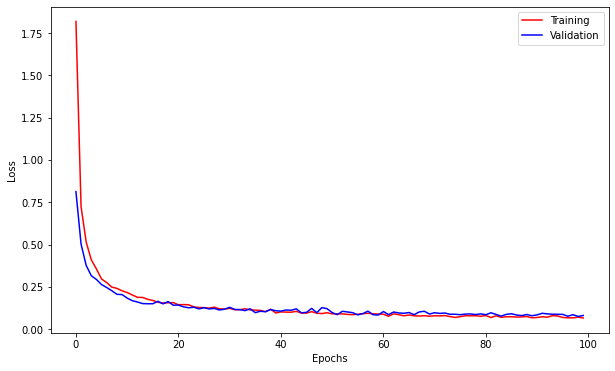

In [13]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

fig = plt.figure(figsize=(10,6))
plt.plot(epochs,loss,c="red",label="Training")
plt.plot(epochs,val_loss,c="blue",label="Validation")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

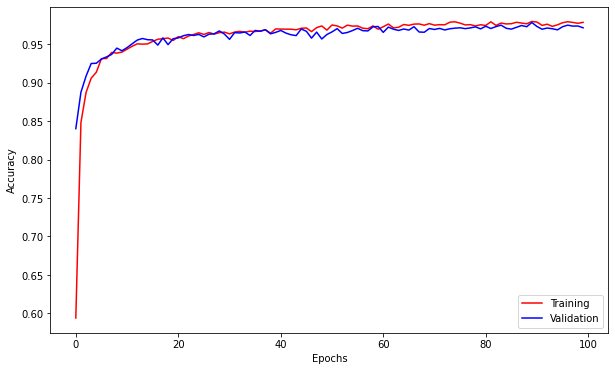

In [14]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

epochs = range(len(acc))

fig = plt.figure(figsize=(10,6))
plt.plot(epochs,acc,c="red",label="Training")
plt.plot(epochs,val_acc,c="blue",label="Validation")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

## Save the model

We finally save the model in the standard TensorFlow 2 SavedModel format.

In [15]:
model.save('final_model.h5')